# Проект: Статистический анализ данных

Представлены данные с сервиса аренды самокатов GoFast, в виде 3 датафреймов: данные пользователя, информация о поездках и виды подписок. 
План: 
- Изучить данные с сервиса аренды самокатов GoFast
- Выполнить предобработку данных, привести данные в оптимальные форматы, проверить пропуски и дубликаты
- Провести исследовательский анализ
- Добавить необходимые столбцы для проверки гипотез

Основная цель проекта - проверить гипотезы, которые могут помочь бизнесу вырасти, а именно:
- Как распределено время поездок пользователей, уделяют ли пользователи с подпиской больше времени пользованию самокатом.
- Верно ли утверждение, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров.
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Сервис предполагает 2 вида пользования - по подписке и без нее: 
1. без подписки:
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra:
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

## Шаг. Загрузка данных

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial
from scipy.stats import binom

In [6]:
#Читаем датасеты
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscription = pd.read_csv('/datasets/subscriptions_go.csv')

In [7]:
users.head(3)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [9]:
rides.head(3)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20


In [13]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [11]:
subscription.head(3)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [12]:
subscription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Вывод разведовательного анализа: 
- В датафреймах отсутствуют пропуски. 
- Данные имеют оптимальные форматы, кроме ```date``` в датафрейме ```rides```.



1. В ```users``` представлена информация о пользователях:

```user_id``` -	уникальный идентификатор пользователя;
```name``` -	имя пользователя;
```age``` - возраст;
```city``` - город;
```subscription_type``` -	тип подписки (free, ultra).


2. В ```rides``` представлена информация о поездках:

```user_id``` -	уникальный идентификатор пользователя;
```distance``` -	расстояние, которое пользователь проехал в текущей сессии (в метрах);
```duration``` -	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
```date``` -	дата совершения поездки.

3. В ```subscription``` информация о типах подписок:

```subscription_type``` -	тип подписки;
```minute_price``` -	стоимость одной минуты поездки по данной подписке;
```start_ride_price``` -	стоимость начала поездки;
```subscription_fee``` -	стоимость ежемесячного платежа.

## Шаг. Предобработка данных

In [14]:
#Переведем графу date в формат даты
rides['date'] = pd.to_datetime(rides['date'])

In [15]:
#Добавляем столбец с номером месяца, в котором совершена поездка
rides['month'] = rides['date'].dt.month

print(f"Минимальная дата: {rides['date'].min()}")
print(f"Максимальная дата: {rides['date'].max()}")

Минимальная дата: 2021-01-01 00:00:00
Максимальная дата: 2021-12-30 00:00:00


Вывод: данные представлены за 1 календарный год

In [16]:
#Проверяем на наличие пропусков и дубликатов графах
print(users.isna().sum())
print(f"Количество дубликатов = {users.duplicated().sum()}")

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
Количество дубликатов = 31


In [17]:
#Удаляем дубликаты
users = users.drop_duplicates().reset_index()

In [18]:
#Проверяем на наличие пропусков и дубликатов графах
print(rides.isna().sum())
print(f"Количество дубликатов = {rides.duplicated().sum()}")

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
Количество дубликатов = 0


В датафрейме subscription только 2 строчки, при первичном ознакомлении не найдены ни дубликаты, ни пропуски.

Вывод по результатам предобработки - данные изначально в хорошем состоянии.

Во время предобработки изменили на корректный формат даты столбец date в датафрейме rides. Добавлен столбец с номером месяца, в котором совершена поездка. Удалены 'очевидные' дубликаты в датафрейме users (31 строка).

## Шаг. Исследовательский анализ данных

Описание и визуализация общей информации о пользователях и поездках.

### 3.1  Частота встречаемости городов¶

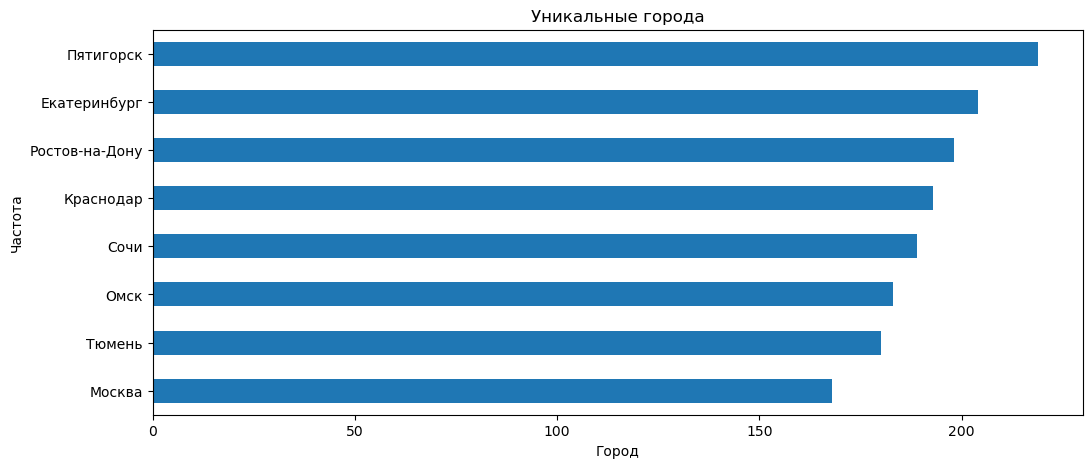

In [19]:
#Создаем сводную таблицу по городам и количеству пользователей, строим график
users_cities = users.pivot_table(index = 'city', values = 'user_id', aggfunc ='count').sort_values(by='user_id').reset_index()
users_cities.plot(kind='barh', x='city', figsize = (12,5))
plt.title('Уникальные города')
plt.xlabel('Город')
plt.ylabel('Частота')
plt.legend().remove()
plt.show()

In [20]:
users_cities

,city,user_id
0,Москва,168
1,Тюмень,180
2,Омск,183
3,Сочи,189
4,Краснодар,193
5,Ростов-на-Дону,198
6,Екатеринбург,204
7,Пятигорск,219


Данные представлены по 8 городам, где больше всего пользователей в Пятигорске (219), а меньше всего в Москве (168).

### 3.2  Соотношение пользователей с подпиской(ultra) и без подписки(free)

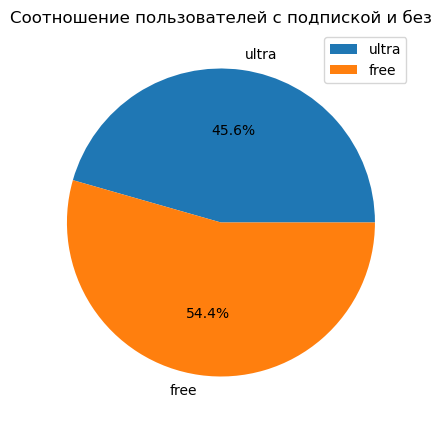

In [21]:
#Создаем сводную таблицу по типам подписки и количеству пользователей, строим график
users_subscription = users.pivot_table(index='subscription_type', values='user_id', aggfunc='count').sort_values(by='user_id')#.reset_index()
users_subscription.plot(kind='pie', y='user_id', autopct='%1.1f%%', figsize = (12,5))
plt.title('Соотношение пользователей с подпиской и без')
plt.ylabel('')
#plt.legend(labels = users_subscription['subscription_type'])
plt.show()

In [22]:
users_subscription

,user_id
subscription_type,
ultra,699
free,835


Количество пользователей с подпиской 'ultra' (699) меньше, чем бользователей без подписки (835).

### 3.3  Возраст пользователей

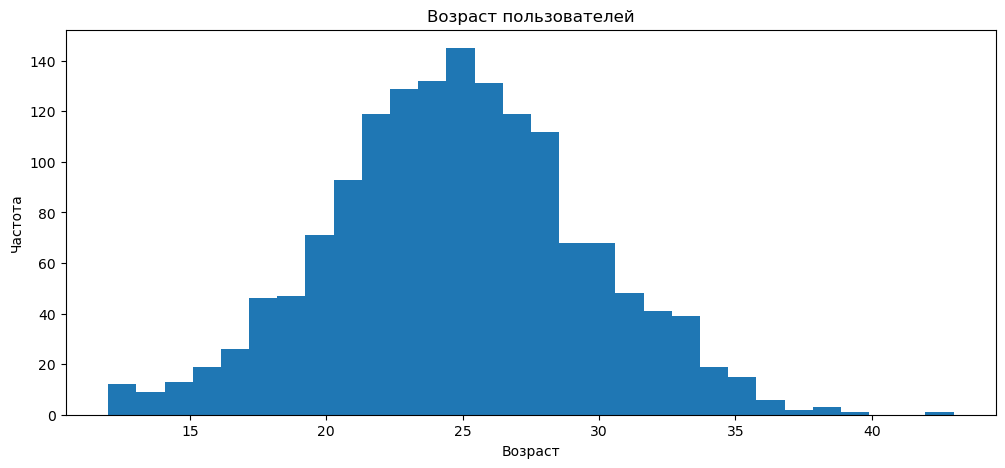

In [23]:
#Строим гистограмму на основе графы возраста
users['age'].plot(kind='hist', bins = 30, figsize = (12,5))
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

In [24]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Возраст пользователей представлен в промежутке от 12 до 43 лет, средний возраст - 24,9 года.

### 3.4  Расстояние, которое пользователь преодолел за одну поездку.

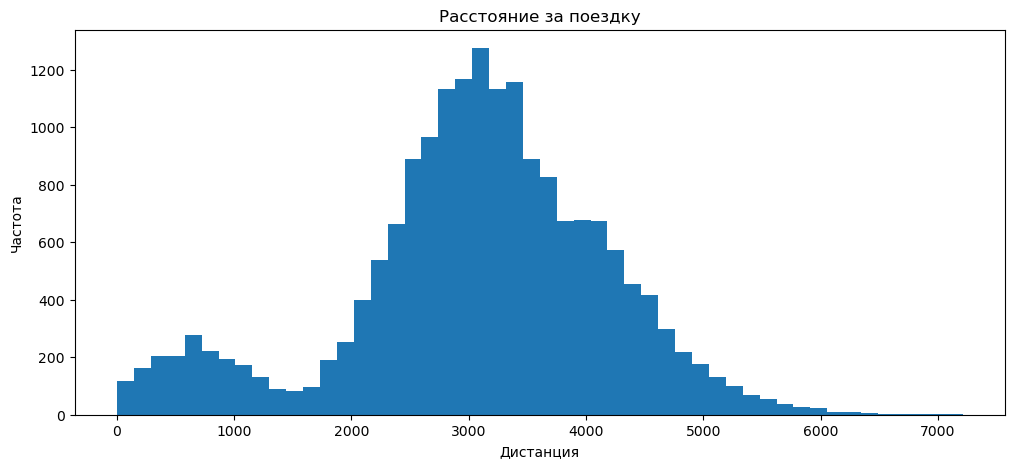

In [25]:
#Строим гистограмму на основе графы дистанции
rides['distance'].plot(kind='hist', bins = 50, figsize = (12,5))
plt.title('Расстояние за поездку')
plt.xlabel('Дистанция')
plt.ylabel('Частота')
plt.show()

In [27]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Расстояние за поездку представлены в промежутке от ~1 метра до 7,2 километров, средняя дистанция на одну поезду ~3 километра. Наблюдается 2 пиковых распределения. Первый небольшой пик можно объяснить тем, что пользователи берут самокат для коротких поездок до ближайшего общественного траспорта и расстояния в маленьких городах будут соответственно короче. Второй пик показывает номрально распределение всех поездок, такие пользователи предпочитают использовать самокат как основой вид транспорта, без пересадок.

### 3.5  Продолжительность поездок

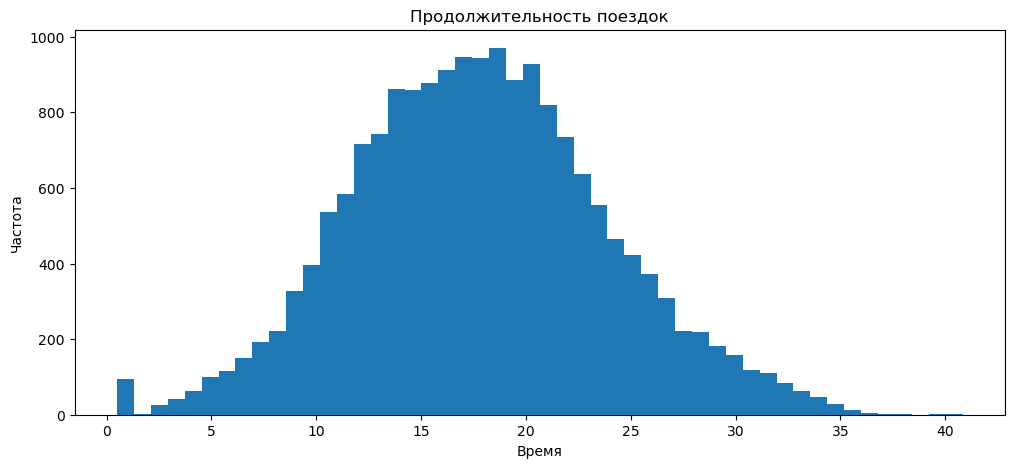

In [28]:
#Строим гистограмму по графе времени
rides['duration'].plot(kind='hist', bins = 50, figsize = (12,5))
plt.title('Продолжительность поездок')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.show()

In [29]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Продолжительность поездок находятся в промежутке от 0,5 минуты до ~41 минут, средняя поездка занимается 17,8 минут. Присутсвует всплеск значений в 0,5 минут, можно предположить, что пользователи в среднем за это время неисправность, а счетчик уже запущен, либо у сервиса есть минимум времени, который можно проехать. Лучше уточнить у сервиса как конкретно у них работает запуск поездки, тогда можно сделать более однозначные выводы.

Выводы из исследовательского анализа:

Данные охватывают 8 городов России: Москва, Тюмень, Омск, Сочи, Краснодар, Ростов-на-Дону, Екатеринбург, Пятигорск. Лидером по количеству пользователей выступает Пятигорск (219)
Пользователей, которые используют сервис без подписки больше, чем пользователей с ней, 835 и 699 соответственно
Сервисом пользуются люди из разных возрастных категорий - от 12 до 43 лет. Максимальное количество пользователей в возрасте 25 лет
За поездку пользователи проезжают расстояние от 1 до 7200 метров, средняя дистанция поездки 3070 метров
Наиболее распространенное время поездки около 18 минут, когда поездка может длится как и полминуты, так и 40 минут.

## Шаг. Объединение данных

In [30]:
#Объединим датафреймы с юзерами и поездками по совпадающему столбцу
df_users_rides = users.merge(rides, on='user_id')
df_users_rides = df_users_rides.merge(subscription, on='subscription_type')
df_users_rides.sample(3)

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
4091,439,440,Амалия,20,Тюмень,ultra,3495.198903,27.064721,2021-10-28,10,6,0,199
2008,216,217,Снежана,18,Пятигорск,ultra,2844.041898,12.419240,2021-12-03,12,6,0,199
8642,859,860,Ольга,22,Краснодар,free,2172.695382,17.345391,2021-02-15,2,8,50,0


In [31]:
#Проверяем совпадает ли количество строк после объединения
if len(df_users_rides) == len(rides):
    print('Количество строк после объединения совпадает')
else:
    print('Перепроверить')

Количество строк после объединения совпадает


In [32]:
#Проверяем, появились ли пропуски
df_users_rides.isnull().sum()

index                0
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [33]:
#Сортируем датафрейм по пользователем без подписки
df_users_rides_free = df_users_rides[df_users_rides['subscription_type'] == 'free']
df_users_rides_free.sample(3)

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
9805,944,945,Александра,31,Сочи,free,2815.863381,16.559488,2021-01-30,1,8,50,0
7612,779,780,Семен,13,Тюмень,free,6112.644835,0.500000,2021-11-23,11,8,50,0
16487,1421,1422,Светлана,33,Тюмень,free,3926.426264,11.423423,2021-02-18,2,8,50,0


In [34]:
#Сортируем датафрейм по пользователем с подпиской 
df_users_rides_ultra = df_users_rides[df_users_rides['subscription_type'] == 'ultra']
df_users_rides_ultra.sample(3)

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
3208,346,347,Злата,24,Москва,ultra,3674.548566,13.186371,2021-12-20,12,6,0,199
4216,454,455,Виталина,15,Ростов-на-Дону,ultra,3147.472807,26.737364,2021-01-09,1,6,0,199
3740,401,402,Эльмира,21,Екатеринбург,ultra,3179.678115,14.671849,2021-10-28,10,6,0,199


### 4.1  Сравнение расстояний для пользователей с подпиский и без

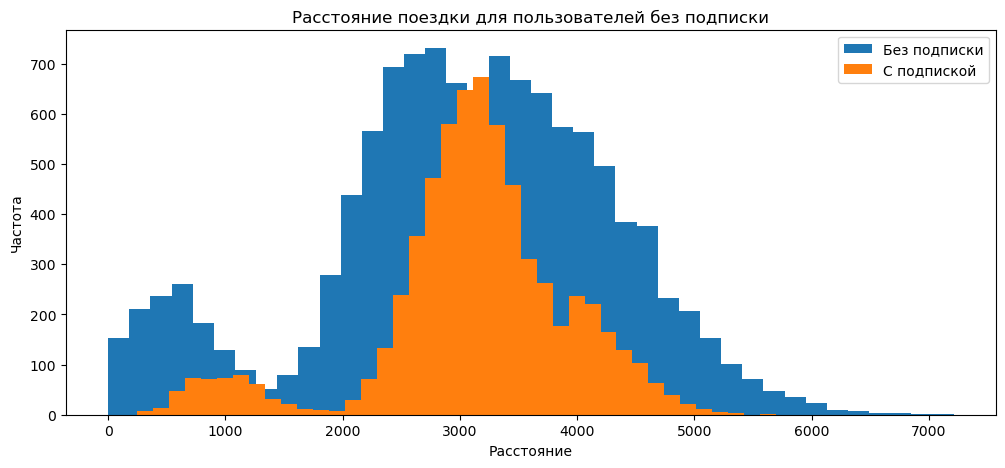

In [35]:
#Строим 2 гистограммы, сроавниваем расстояние и время для пользователей с подпиской и без
df_users_rides_free['distance'].plot(kind='hist', bins = 40, figsize = (12,5), label='Без подписки')
df_users_rides_ultra['distance'].plot(kind='hist', bins = 40, figsize = (12,5), label='С подпиской')
plt.title('Расстояние поездки для пользователей без подписки')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [36]:
df_users_rides_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [37]:
df_users_rides_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Вывод: расстояние поездок с подпиской и без имеют нормальное распределение, примечательно, что присутствуют похожий пик, который приходятся на начало поездки и являются относительными короткими. Предположительно такие пользователи используют самокат для коротких поездок до следующей пересадки на более масшатбный транспорт. В среднем пользователи с подпиской проезжают больше расстояние, чем пользователи без нее.

### Сравнение времени поездки для пользователей с подпиский и без

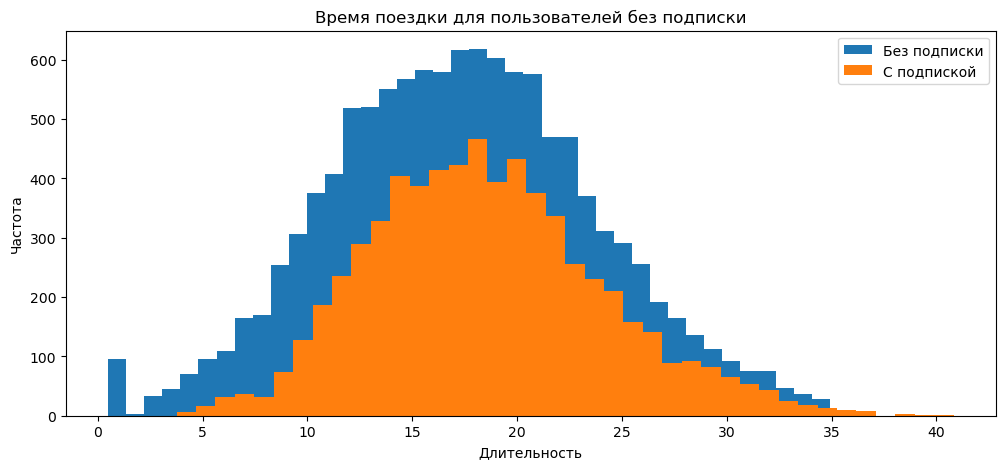

In [38]:
df_users_rides_free['duration'].plot(kind='hist', bins = 40, figsize = (12,5), label='Без подписки')
df_users_rides_ultra['duration'].plot(kind='hist', bins = 40, figsize = (12,5), label='С подпиской')
plt.title('Время поездки для пользователей без подписки')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [39]:
df_users_rides_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [40]:
df_users_rides_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Вывод: время поездок для пользователей с подпиской и без нее имеют нормальное распределение. Время поездки пользователей без подписки в среднем меньше, чем у пользователей с ней.

## Шаг. Подсчёт выручки

In [41]:
#Округляем продолжительность поездки в большую стророну
df_users_rides['duration'] = np.ceil(df_users_rides['duration'])
#Создаем датафрейм, в котором найдем суммарное расстояние, количество поездок, и суммарное время для пользователя по месяцам
df_cnt_sum = df_users_rides.pivot_table(index= ['user_id', 'month'], values = ['distance','duration'],
    aggfunc = {'distance': 'sum', 'duration': ['count', 'sum']}).reset_index()
df_cnt_sum.sample(3)

user_id month      distance duration      
                             sum    count   sum
6965    1003     1   2538.601466        1  17.0
8453    1186     5  12053.496501        3  73.0
2247     346     6   2676.418333        1  16.0

In [42]:
#Переименуем столбцы, чтобы избавиться от 2этажных названий
df_cnt_sum.columns = ['user_id', 'month', 'total_distance', 'trips_count', 'duration_sum']
df_cnt_sum.sample(3)

,user_id,month,total_distance,trips_count,duration_sum
11091,1507,9,7267.013332,2,36.0
9688,1333,12,3170.642226,1,13.0
11293,1530,6,2587.068383,1,17.0


In [43]:
#Объединим датафреймы по номеру юзера
df_cnt_sum = df_cnt_sum.merge(users, how='left', on='user_id')
df_cnt_sum.sample(3)

,user_id,month,total_distance,trips_count,duration_sum,index,name,age,city,subscription_type
1053,162,12,2680.434182,1,17.0,161,Тамара,24,Москва,ultra
1794,273,9,6353.184054,2,42.0,272,Виолетта,30,Омск,ultra
6751,977,5,4577.165423,2,22.0,976,Амалия,22,Москва,free


In [44]:
#Объединим датафреймы по типу подписки
df_cnt_sum = df_cnt_sum.merge(subscription, how='left', on='subscription_type')
df_cnt_sum.sample(3)

,user_id,month,total_distance,trips_count,duration_sum,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
604,93,4,7250.702439,2,33.0,92,Вадим,25,Пятигорск,ultra,6,0,199
362,58,6,3136.925683,1,18.0,57,Ян,22,Пятигорск,ultra,6,0,199
4156,635,12,266.123499,1,4.0,634,Герман,21,Москва,ultra,6,0,199


In [45]:
#Добавляем столбец с помесячной выручкой
df_cnt_sum['value'] = (df_cnt_sum['start_ride_price'] * df_cnt_sum['trips_count'] + df_cnt_sum['minute_price'] 
                       * df_cnt_sum['duration_sum'] + df_cnt_sum['subscription_fee'])
df_cnt_sum.sample(3)

,user_id,month,total_distance,trips_count,duration_sum,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,value
5282,794,3,3185.489935,2,35.0,793,Андрей,29,Москва,free,8,50,0,380.0
1800,274,10,4352.267631,1,29.0,273,Гордей,29,Омск,ultra,6,0,199,373.0
7528,1070,12,4686.567123,1,28.0,1069,Яна,30,Екатеринбург,free,8,50,0,274.0


In [46]:
df_cnt_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11331 non-null  int64  
 1   month              11331 non-null  int32  
 2   total_distance     11331 non-null  float64
 3   trips_count        11331 non-null  int64  
 4   duration_sum       11331 non-null  float64
 5   index              11331 non-null  int64  
 6   name               11331 non-null  object 
 7   age                11331 non-null  int64  
 8   city               11331 non-null  object 
 9   subscription_type  11331 non-null  object 
 10  minute_price       11331 non-null  int64  
 11  start_ride_price   11331 non-null  int64  
 12  subscription_fee   11331 non-null  int64  
 13  value              11331 non-null  float64
dtypes: float64(3), int32(1), int64(7), object(3)
memory usage: 1.2+ MB


Вывод: на данном шаге получили новый датафрейм, в котором появились новые столбцы:
1. ```total_distance``` - пройденное за месяц расстояние
2. ```trips_count``` - количество поездок за месяц
3. ```duration_sum``` - продолжительность поездки за месяц
4. ```value``` - выручка по пользователю за месяц.

## Шаг. Проверка гипотез

###  Пользователи с подпиской тратят больше времени на пользование сервисом

Нулевая гипотеза - время поездок пользователей с подпиской и пользователей без подписки равны 

Альтернативная гипотеза - пользователи с подпиской тратят больше времени на поездку

In [47]:
#Задаем уровень значимости
alpha = .05
#Используем метод для 2х независимых выборок для правосторонней гипотезы
results = st.ttest_ind(df_users_rides_ultra['duration'], df_users_rides_free['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [48]:
#Перепроверим результаты
print(f"Среднее время юзеров c подпиской = {df_users_rides_ultra['duration'].mean()}")
print(f"Среднее время юзеров без подписки = {df_users_rides_free['duration'].mean()}")

Среднее время юзеров c подпиской = 18.54198516280583
Среднее время юзеров без подписки = 17.39090929866399


Вывод: пользователи с подпиской в среднем тратят на поездку больше времени.

### Расстояние, которое проезжают пользователи с подпиской за поездку не превышает 3130 метров

Нулевая гипотеза - расстояние поездки пользователи с подпиской равна 3130 метрам

Альтернативная гипотеза - расстояние поездки пользователи с подпиской больше 3130 метров

In [49]:
#Задаем показатель расстояния
interested_value = 3130
#Задаем уровень значимости
alpha = .05
#Используем метод для оценки равенства числу из нулевой гипотезы
results = st.ttest_1samp(df_users_rides_ultra['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Вывод: расстояние, которое преодолевают пользователи с подпиской меньше или равно 3130 метрам.

### Помесячная выручка от пользователей с подпиской больше, чем без нее

Нулевая гипотеза - выручка от пользователей с подпиской равна выручке без подписки

Альтернативная гипотеза - выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

In [53]:
#Задаем уровень значимости
alpha = .05
#Используем метод для 2х независимых выборок для правосторонней гипотезы
results = st.ttest_ind(df_cnt_sum[df_cnt_sum['subscription_type'] == 'ultra']['value'],
                       df_cnt_sum[df_cnt_sum['subscription_type'] == 'free']['value'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [54]:
#Перепроверим результаты
print(f"Средняя помесячная выручка юзеров c подпиской = {df_cnt_sum[df_cnt_sum['subscription_type'] == 'ultra']['value'].mean()}")
print(f"Средняя помесячная выручка юзеров без подписки = {df_cnt_sum[df_cnt_sum['subscription_type'] == 'free']['value'].mean()}")

Средняя помесячная выручка юзеров c подпиской = 362.7921906022502
Средняя помесячная выручка юзеров без подписки = 328.6413651073845


Вывод: помесячная выручка от пользователей с подпиской больше, чем без нее

### Количество обращений в техсап снизится после обновления

Дана ситуация: Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Решение: Чтобы проверить гипотезу необзодимо применить метод сравнения 2 совокупностей для зависимых выборок до и после изменения - **st.ttest_rel()**.

## Шаг.  Распределения

### Акция с промокодами

Дана ситуация: необходимо выполнить план по продлениям подписок 100 клиентами путем рассылки промокодов. Есть информация, что вероятность продления 10%. План должен выполнится с вероятностью неудачи не более 5%. Оценить, сколько нужно минимум разослать промокодов.

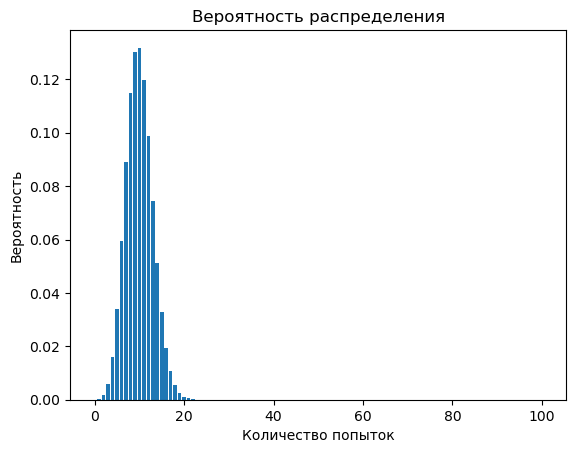

In [55]:
#Задаем количество попыток
n = 100
#Задаем вероятность успеха
p = .1

distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)
    
plt.bar(range(0, n + 1), distr)
plt.xlabel('Количество попыток')
plt.ylabel('Вероятность')
plt.title('Вероятность распределения')
plt.show()

In [56]:
#Подбираем значение в цикле
for n in range(1000, 3000):
    if binom.cdf(99, n, 0.1) <= 0.05:
        n_number = n
        break
n_number

1161

Вывод: необходимо разослать не менее 1161 промокодов для выполнения плана на 95% и выше.

### Рассылка уведомлений

Дана ситуация: отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. Оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [57]:
# задаём параметры биномиального распределения
n = 1000000
p = .4
# зададим мат.ожидание и ст.отклонение нормального распределения
mu = n * p
sigma = (n * p * (1 - p))**.5
# задаём нормальное распределение
distr = st.norm(mu, sigma)

# считаем вероятность получить значение, равное или меньше 
result = distr.cdf(399500)
result

0.15371708296369768

Вывод: с вероятностью ~15% уведомления откроют не более 399500 пользователей, согласно акции с рассылкой 1кк уведомлений

## Общий вывод

Проведена работа с целью анализа данных сервиса аренды самокатов. Была проведена предобработка данных и приведение к оптимальным типам данных, были уделены дублирующиеся значения. Сами данные были предоставлены в качественном виде с отсутствием пропусков.

Исследовательский анализа показал:
- Предоставлены данные для 8 городов, больше всего пользователей из Пятигорска
- Пользователей, которые используют сервис без подписки больше, примерно на 19,6%
- Сервисом пользуются люди в возрасте от 12 до 43 лет. Больше всего представлены пользователи в возрасте 25 лет
- Среднее расстояние за поездку составляет 3,07 километра 
- Наиболее распространенное время поездки около 18 минут.

Был создан новый датафрейм в котором добавились столбцы: номер месяца, пройденное пользователем расстояние за месяц, количество поездок для пользователя за месяц, продолжительность поездки за месяц и выручка.

Решены поставленные задачи:
- Пользователи, имеющие подписку тратят на поездку больше времени, чем пользователи без нее
- Можно утверждать, что пользователи, имеющие подписку проезжают в среднем менее 3130 метров
- Больше выручки приносят пользователи, имеющие подписку на сервис
- Для выполнения плана по продлению подписок необходимо разослать не менее 1161 промокодов
- В акции с рассылкой 1кк уведомлений около 15% вероятность, что их откроют не более 399500 пользователей.

Сервису можно порекомендовать сконцентрировать больше внимание на пользователях с подпиской, так как они дольше пользуются самокатами и приносят больше дохода. Можно назвать хорошей практикой введение платных подписок, стоит подумать о добавлении бОльших вариаций, чтобы привлечь и внимание пользователей, которые сейчас подписку не используют, а их большинство. Стоит увеличить износостойкость самокатов, так как 3 километра - это низкий показатель для больших городов, что и показывает низкую популярность в Москве, по отношению к более скромным по размерам городам.